# Monte Carlo Simulation for Predicting Project Failure

In this notebook, we will perform a Monte Carlo simulation analysis for project WALM-1032-01-00. The simulation is based on a numerical representation of the risk probability and associated severity for every risk in the project risk profile.

In doing this, we will create a probability distribution of potential outcomes based on 10,000 iterations of the simulation. This should enable project managers and other key stakeholders to assess the likelihood of project success or failure and identify risks for mitigation.

- During the simulation, the program iterates down the profile of risks in the projects and samples from a binomial distribution based on a probability we give. This produces a binary outcome - 0 or 1 - (0 to represent the risk not occurring and 1 to represent the risk occurring). 
- If the outcome for a risk is 1, then the program will add the associated severity to an overall score for the simulation. If the outcome is 0, the severity score is not added to the cumulative total. The program then moves to the next risk and continues in this way until it has looked at all risks in the risk profile.
- This process is repeated 10,000 times, and the output is a set of 10,000 simulation scores which can then be plotted.

Let's import the packages and the data we will need. Currently, we have risk profile data for 6 projects overall, but for demo purposes we will show the process of the analysis for just one project:

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
full_data = pd.read_csv('Consolidated_Risk_Register_v1.0.csv', header=1)

In [70]:
full_data

,Sr. No.,Project ID,Project Name,Risk Class,Risk Element,Risk Attribute,Risk Description,Impact,Response Action / Mitigation,Probability,Severity,Risk Rating,Risk Assessment,Risk Response
0,1,WALM-1032-01-00,Sustainability Programs,Program,Operations,Contract,Contract for 2020 is not signed,NaN,NaN,Low,High,Amber,Close monitoring required,Avoid
1,2,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Contractual/Verbal commitments,Availability of SME from Walmart business thro...,NaN,Business owner identified for the project. Nee...,Medium,Medium,Amber,Management recommended,Transfer
2,3,WALM-1032-01-00,Sustainability Programs,Program,Information Security,Access Control,"Access and information about existing systems,...",NaN,Escalate to Walmart management and communicate...,Medium,Medium,Amber,Management recommended,Mitigate
3,4,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Reviews/Sign-offs,Approvals not in place for project backlog ite...,NaN,Plan monthly meeting and pursue for approval b...,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Mitigate
4,5,WALM-1032-01-00,Sustainability Programs,Program,Information Security,Access Control,Walmart VDI and System Access,NaN,Existing team access to be extended after the ...,Medium,Medium,Amber,Management recommended,Avoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,USTG010829UTCO,NE CRM Global Template,Program,Information Security,Access Control,Security model and access matrix structure de...,NaN,NaN,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Accept
86,87,USTG010829UTCO,NE CRM Global Template,Program,Information Security,Access Control,Otis infrastructure security policy and restri...,This may get stuck into the passport gate proc...,Restrictions need to be analysed and alternati...,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Accept
87,88,USTG010829UTCO,NE CRM Global Template,Infrastructure,Infrastructure,Compliance,System compliance risks identified for Turkey ...,NaN,Meet with OTIS internal legal compliance team ...,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Avoid
88,89,USTG010829UTCO,NE CRM Global Template,Program,Dependency,Tracking,eLog handshaking issues are not resolved. The ...,NaN,eLog team needs to convey changes in single de...,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Mitigate


In [71]:
full_data['Project ID'].unique()

array(['WALM-1032-01-00', 'WALM-xxxx-xx-xx', 'WALM-1067-01-00',
       'WALM-1070-01-00', 'OTIS-xxxx-xx-xx', 'USTG010829UTCO'],
      dtype=object)

In [72]:
project1 = full_data[full_data['Project ID'] == 'WALM-1032-01-00']

# First Project Only:

Now, we need to encode the categorical risk probability and risk severity variables to numerical data. In coordination with Srini, I have encoded the risk probabilities as follows:

**Low risk** = 0.1 (occurring 1 in 10 times)

**Medium risk** = 0.5 (occurring 5 in 10 times)

**High risk** = 0.8 (occurring 8 in 10 times)

For the severity column, I have given each level of severity a score that will be added to the cumulative score for each simulation should the probability outcome resolve to 1. I have encoded the severities as follows:

**Low severity** = 1

**Medium severity** = 3

**High severity** = 5

It is important to note that these numbers can be changed based on the expertise of project managers who may, for example, deem low probabilty risks to occur 3 in 10 times (p=0.3).

### Encoding Categorical Probability to Numerical Probability:

In [73]:
nums = []

for x in project1['Probability']:
    if x == 'Low':
        nums.append(0.1)
    elif x == 'Medium':
        nums.append(0.5)
    elif x == 'High':
        nums.append(0.8) 

In [74]:
project1['Numerical Probability'] = nums

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Encoding Categorical Severity to Numerical Severity:

In [75]:
nums = []

for x in project1['Severity']:
    if x == 'Low':
        nums.append(1)
    elif x == 'Medium':
        nums.append(3)
    elif x == 'High':
        nums.append(5) 

In [76]:
project1['Numerical Severity'] = nums

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


As we can now see in the dataset below, we have two new columns - 'Numerical Probability' and 'Numerical Severity'.

In [77]:
project1

,Sr. No.,Project ID,Project Name,Risk Class,Risk Element,Risk Attribute,Risk Description,Impact,Response Action / Mitigation,Probability,Severity,Risk Rating,Risk Assessment,Risk Response,Numerical Probability,Numerical Severity
0,1,WALM-1032-01-00,Sustainability Programs,Program,Operations,Contract,Contract for 2020 is not signed,NaN,NaN,Low,High,Amber,Close monitoring required,Avoid,0.1,5
1,2,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Contractual/Verbal commitments,Availability of SME from Walmart business thro...,NaN,Business owner identified for the project. Nee...,Medium,Medium,Amber,Management recommended,Transfer,0.5,3
2,3,WALM-1032-01-00,Sustainability Programs,Program,Information Security,Access Control,"Access and information about existing systems,...",NaN,Escalate to Walmart management and communicate...,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3
3,4,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Reviews/Sign-offs,Approvals not in place for project backlog ite...,NaN,Plan monthly meeting and pursue for approval b...,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Mitigate,0.1,3
4,5,WALM-1032-01-00,Sustainability Programs,Program,Information Security,Access Control,Walmart VDI and System Access,NaN,Existing team access to be extended after the ...,Medium,Medium,Amber,Management recommended,Avoid,0.5,3
5,6,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Decisions,Dependency on Walmart DBAs for migrating Datab...,NaN,Plan and Raise JIRA and CRQ tickets in advance...,Medium,Medium,Amber,Management recommended,Transfer,0.5,3
6,7,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Reviews/Sign-offs,DB migration to Azure in CERT and PROD is bloc...,DB Migration to Azure cloud will be delayed if...,\n1. Request for Azure capacity.\n2. Identify ...,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3
7,8,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Decisions,Special projects – Contents from Joby and url ...,NaN,NaN,Medium,Medium,Amber,Management recommended,Transfer,0.5,3
8,9,WALM-1032-01-00,Sustainability Programs,Product,Requirements,Size of Changes,Resource planning and financials – Antibiotic ...,Potential descope of 80k from TCV\n,NaN,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3
9,10,WALM-1032-01-00,Sustainability Programs,Product,Requirements,Scope Creep,Gigaton two new calculator – requirements pending,NaN,NaN,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3


## Simulating:

Now we will perform the simulation 10,000 times and create a set of 10,000 simulation scores.

In [78]:
ticker = 0
simulation_scores = []

while ticker <10000:
    score=0
    for index, row in project1.iterrows():
        x = np.random.binomial(n=1, p=row['Numerical Probability'])
        if x == 1:
            score = score + row['Numerical Severity']
        elif x ==0:
            score +=0
    simulation_scores.append(score)
    
    ticker+=1

In [79]:
max(simulation_scores)

38

In [80]:
min(simulation_scores)

3

In [81]:
scores_df = pd.DataFrame(simulation_scores, columns=['Simulation Score'])

## Plotting:

So, now that we have the outcome of our simulation, we can plot the scores and apply some more meaningful project outcome bandings:

Text(0.5, 1.0, 'Simulated Outcome Distribution Plot')

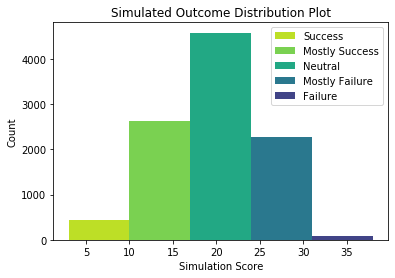

In [82]:
N, bins, patches = plt.hist(scores_df['Simulation Score'], 5)

cmap = plt.get_cmap('viridis')
a = cmap(0.9)
b =cmap(0.8)
c = cmap(0.6)
d= cmap(0.4)
e=cmap(0.2)


for i in range(0,4):
    patches[0].set_facecolor(a)
    patches[0].set_label('Success')
    
    patches[1].set_facecolor(b)
    patches[1].set_label('Mostly Success')
    
    patches[2].set_facecolor(c)
    patches[2].set_label('Neutral')
    
    patches[3].set_facecolor(d)
    patches[3].set_label('Mostly Failure')
    
    patches[4].set_facecolor(e)
    patches[4].set_label('Failure')

plt.legend()
plt.xlabel('Simulation Score')
plt.ylabel('Count')
plt.title('Simulated Outcome Distribution Plot')

So, as we can see, from our Monte Carlo simulation analysis for this project, it would predict that the most likely outcome for this project is 'Neutral'.

# Assumptions:

1) Encoded risk probabilities are an accurate portrayal of real-life chance of risk occurrence (Low: 0.1, Medium: 0.5, High: 0.8)

2) Encoded risk severities are accurately portrayed relative to one another were they to occur in real-life (Low: 1, Medium: 3, High: 5)

It is important to note that, were the input numerical risk probability and severities were to change based on recommendations from project managers, the outcome distribution would invariably change also.

## Identifying risks to mitigate:

We can visualise which risks are having the biggest impact on the simulation by plotting a simple scatter plot. This can quickly identify the risks where mitigation will have the biggest overall impact on the project outcome.

In [109]:
project1['Numerical Rating'] = project1['Numerical Probability'] * project1['Numerical Severity']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
project1

,Sr. No.,Project ID,Project Name,Risk Class,Risk Element,Risk Attribute,Risk Description,Impact,Response Action / Mitigation,Probability,Severity,Risk Rating,Risk Assessment,Risk Response,Numerical Probability,Numerical Severity,Numerical Rating
0,1,WALM-1032-01-00,Sustainability Programs,Program,Operations,Contract,Contract for 2020 is not signed,NaN,NaN,Low,High,Amber,Close monitoring required,Avoid,0.1,5,0.5
1,2,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Contractual/Verbal commitments,Availability of SME from Walmart business thro...,NaN,Business owner identified for the project. Nee...,Medium,Medium,Amber,Management recommended,Transfer,0.5,3,1.5
2,3,WALM-1032-01-00,Sustainability Programs,Program,Information Security,Access Control,"Access and information about existing systems,...",NaN,Escalate to Walmart management and communicate...,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3,1.5
3,4,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Reviews/Sign-offs,Approvals not in place for project backlog ite...,NaN,Plan monthly meeting and pursue for approval b...,Low,Medium,Green,"Risk may be accepted, but requires monitoring",Mitigate,0.1,3,0.3
4,5,WALM-1032-01-00,Sustainability Programs,Program,Information Security,Access Control,Walmart VDI and System Access,NaN,Existing team access to be extended after the ...,Medium,Medium,Amber,Management recommended,Avoid,0.5,3,1.5
5,6,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Decisions,Dependency on Walmart DBAs for migrating Datab...,NaN,Plan and Raise JIRA and CRQ tickets in advance...,Medium,Medium,Amber,Management recommended,Transfer,0.5,3,1.5
6,7,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Reviews/Sign-offs,DB migration to Azure in CERT and PROD is bloc...,DB Migration to Azure cloud will be delayed if...,\n1. Request for Azure capacity.\n2. Identify ...,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3,1.5
7,8,WALM-1032-01-00,Sustainability Programs,Program,Stakeholder Dependency,Timeliness and/or Quality of Decisions,Special projects – Contents from Joby and url ...,NaN,NaN,Medium,Medium,Amber,Management recommended,Transfer,0.5,3,1.5
8,9,WALM-1032-01-00,Sustainability Programs,Product,Requirements,Size of Changes,Resource planning and financials – Antibiotic ...,Potential descope of 80k from TCV\n,NaN,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3,1.5
9,10,WALM-1032-01-00,Sustainability Programs,Product,Requirements,Scope Creep,Gigaton two new calculator – requirements pending,NaN,NaN,Medium,Medium,Amber,Management recommended,Mitigate,0.5,3,1.5


From the plot below, we can see that the risks can be banded into three separate levels based on the combination of their probability and severity scores. It follows logically that mitigating the highest risks as shown in this plot will have the biggest effect on the simulation score and thus the predicted outcome of the project. These are the risks which should be targeted first, followed by the next level of risks and so on.

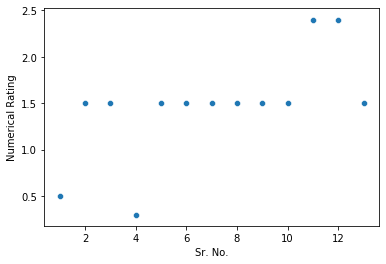

In [111]:
sns.scatterplot(x=project1['Sr. No.'], y=project1['Numerical Rating'])